In [2]:
import sys

import matplotlib.pyplot as plt
import torch
from tqdm import tqdm

sys.path.insert(0, "../")

%load_ext autoreload
%autoreload 2

/cvlabdata2/home/davydov/miniconda3/envs/hmr_ssl/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import src
from src.datasets.coco_eft import COCO_EFT
from src.datasets.datasets_common import UNNORMALIZE
from src.datasets.threedpw import ThreeDPW
from src.functional import smpl
from src.utils import img_utils, vis_utils, video_utils
import numpy as np
import cv2 
import src.utils.img_utils_datasets_3d as img_utils_datasets_3d

from src.utils.img_utils import perspective_projection

import pickle as pkl

import cv2
import os

In [4]:
from src.functional import smpl

device = "cuda:0"
smpl_model = smpl.get_smpl_model("h36m").to(device)
faces = smpl_model.faces.astype(int)

In [5]:
fps = 30
savepath = "/cvlabdata2/home/davydov/videoHMR_SSL/output/test_OF_quality/" # for videos
dataset_path = "/cvlabdata2/home/davydov/videoHMR_SSL/data/3dpw/3dpw_original"

In [6]:
### process GT "downtown_runForBus_01" sequence
seq_name = "downtown_runForBus_01"
seq_path = f"/cvlabdata2/home/davydov/videoHMR_SSL/data/3dpw/3dpw_original/sequenceFiles/test/{seq_name}.pkl"
data = pkl.load(open(seq_path, 'rb'), encoding='latin1')
# print(data.keys())

person_num = 0
cam_extrinsics = data["cam_poses"]
num_frames_total = len(cam_extrinsics)
shape = data["betas"][person_num][None, :10]
shape = np.tile(shape, (num_frames_total, 1))
pose = data["poses"][person_num]
cam_R = cam_extrinsics[:, :3, :3]
cam_t = cam_extrinsics[:, :3, 3]
frame_trans = data["trans"][person_num]
cam_K = data["cam_intrinsics"][None, ...]
cam_K = np.tile(cam_K, (num_frames_total, 1, 1))

pose = torch.from_numpy(pose).float().to(device)
shape = torch.from_numpy(shape).float().to(device)
cam_t = torch.from_numpy(cam_t).float().to(device)
cam_R = torch.from_numpy(cam_R).float().to(device)
frame_trans = torch.from_numpy(frame_trans).float().to(device)
cam_K = torch.from_numpy(cam_K).float().to(device)

smpl_out = smpl_model(body_pose=pose[:, 3:], global_orient=pose[:, :3], betas=shape, transl=frame_trans)
vertices = smpl_out.vertices
verts_GT = img_utils.perspective_projection(vertices, cam_R, cam_t, cam_K=cam_K)

verts_GT = verts_GT.cpu().numpy()
print(verts_GT.shape)

(783, 6890, 3)


In [57]:
# ### are the 2d joints correct?
# print(data.keys())

# person_num = 0

# frames_out = []
# for frame_idx in tqdm(range(len(verts_GT))):
#     image_file = os.path.join(dataset_path, 'imageFiles', seq_name, f'image_{frame_idx:05}.jpg')
#     img = cv2.cvtColor(cv2.imread(image_file), cv2.COLOR_BGR2RGB)  
#     j2d = data["poses2d"][person_num].transpose(0,2,1)[frame_idx]
#     mask = j2d[:, 2] > 0.3
#     j2d = j2d[mask, :2]
#     for kpt in j2d:
#         img = cv2.circle(img, (int(kpt[0]),int(kpt[1])), radius=10, color=(255,0,0), thickness=-1)
#     frames_out.append(img)
    
# video_utils.write_video(frames_out, f"{savepath}{seq_name}__seqlen{len(frames_out)}__GT_kpts_2d.mp4", fps=fps)

# 2D kpts from 3DPW CAN BE USED! 
## They are well aligned with the body on the image!

In [6]:
### FULL GT video sequence

# frames_out = []
# for frame_idx in tqdm(range(len(verts_GT))):
#     image_file = os.path.join(dataset_path, 'imageFiles', seq_name, f'image_{frame_idx:05}.jpg')
#     img = cv2.cvtColor(cv2.imread(image_file), cv2.COLOR_BGR2RGB)  
#     verts_ = verts_GT[frame_idx].copy()
#     verts_[:, 2] *= 100

#     blend_img = vis_utils.render_mesh_onto_image(img, verts_, faces, device=device)
#     frames_out.append(blend_img)


# video_utils.write_video(frames_out, f"{savepath}{seq_name}__seqlen{len(frames_out)}__GT.mp4", fps=fps)


In [7]:
dset = ThreeDPW(set="test", seqlen=700, debug=True)

print(len(dset))
x = dset[0]
print(x.keys(), x["video"].shape)


video = UNNORMALIZE(x['video']).permute(0,2,3,1)
bbox = x['bbox']

person_num = 0 
### 783 - total length of the sequence

num_frames = len(video)
print("len video: ", num_frames)

print(len(x["instance_id"]))

3DPW Dataset overlap ratio:  0.0
Loaded 3dpw dataset from /cvlabdata2/home/davydov/videoHMR_SSL/data/3dpw/3dpw_processed/test/3dpw_test_db.pt
3dpw - number of dataset objects 29
29
dict_keys(['features', 'theta', 'kp_2d', 'kp_3d', 'w_smpl', 'w_3d', 'instance_id', 'bbox', 'video']) torch.Size([700, 3, 224, 224])
len video:  700
700


In [8]:
### GT sequence but frames from preprocessed seq only!

# frames_out = []

# for instance_id in tqdm(x["instance_id"]):
#     frame_idx = int(instance_id.split('/')[-1])
#     image_file = os.path.join(dataset_path, 'imageFiles', seq_name, f'image_{frame_idx:05d}.jpg')
#     img = cv2.cvtColor(cv2.imread(image_file), cv2.COLOR_BGR2RGB)  
#     verts_ = verts_GT[frame_idx].copy()
#     verts_[:, 2] *= 100

#     blend_img = vis_utils.render_mesh_onto_image(img, verts_, faces, device=device)
#     frames_out.append(blend_img)


# video_utils.write_video(frames_out, f"{savepath}{seq_name}__seqlen{len(frames_out)}__GT__dsetcut.mp4", fps=fps)


In [9]:
# torch.save(x['instance_id'], 
#           f"{savepath}{seq_name}__seqlen{len(x['instance_id'])}__dsetcut_instance_id.pth")

In [10]:
# ### crop the GT sequence acc. to bboxes

# verts_aligned = []
# for bbox_, instance_id in tqdm(zip(bbox, x["instance_id"])):
#     frame_idx = int(instance_id.split('/')[-1])
#     verts_aligned_ = verts_GT[frame_idx].copy()
#     verts_aligned_[:, :2], trans = img_utils_datasets_3d.transform_keypoints(
#         kp_2d=verts_aligned_[:, :2],
#         center_x=bbox_[0],
#         center_y=bbox_[1],
#         width=bbox_[2],
#         height=bbox_[3],
#         patch_width=224,
#         patch_height=224,
#         do_augment=False,
#     )
#     verts_aligned.append(verts_aligned_)
    
# verts_aligned = np.stack(verts_aligned)
# print(verts_aligned.shape)

In [11]:
### save videos

# frames_out = []
# for img_, verts_aligned_ in tqdm(zip(video.numpy().copy(), verts_aligned.copy())):
#     verts_aligned_[:, 2] *= 100

#     blend_img = vis_utils.render_mesh_onto_image(img_, verts_aligned_, faces, device=device)
#     frames_out.append(blend_img)

    
# video_utils.write_video(frames_out, 
#                         f"{savepath}{seq_name}__seqlen{len(frames_out)}__GT__dsetcut_bbox.mp4", fps=fps)

# ### save original video (w/o bodies)
# video_utils.write_video(video.numpy().copy().astype(np.uint8), 
#                         f"{savepath}{seq_name}__seqlen{len(frames_out)}__ORIG_dsetcut_bbox.mp4", fps=fps)

# torch.save(x['video'], 
#            f"{savepath}{seq_name}__seqlen{len(frames_out)}__ORIG_dsetcut_bbox_img.pth")

# ### save GT vertices aligned with bbox bodies
# torch.save(torch.tensor(verts_aligned), 
#            f"{savepath}{seq_name}__seqlen{len(frames_out)}__GT_dsetcut_bbox_verts.pth")

# HMR predictions

In [12]:
from src.models.hmr import get_hmr
hmrnet_best = get_hmr(pretrained=True)
hmrnet_best_path = "/cvlabdata2/home/davydov/videoHMR_SSL/eft_model_zoo/coco-all.pt"
ckpt = torch.load(hmrnet_best_path, map_location=device)
hmrnet_best.load_state_dict(ckpt["hmrnet_state_dict"])
hmrnet_best = hmrnet_best.to(device)
hmrnet_best.eval()

seqlen = 700
video = torch.load(f"{savepath}{seq_name}__seqlen{seqlen}__ORIG_dsetcut_bbox_img.pth")
smpl_model_49 = smpl.get_smpl_model("extra", device=device)
MAX_BATCH = 32
img_size = 224

/cvlabdata2/home/davydov/miniconda3/envs/hmr_ssl/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/cvlabdata2/home/davydov/miniconda3/envs/hmr_ssl/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/cvlabdata2/home/davydov/miniconda3/envs/hmr_ssl/lib/python3.10/site-packages/torch/hub.py:704: UserWarning: TORCH_MODEL_ZOO is deprecated, please use env TORCH_HOME instead
  warnings.warn('TORCH_MODEL_ZOO is deprecated, please use env TORCH_HOME instead')


In [13]:
verts3d_best_arr = []
with torch.no_grad():
    for video_ in torch.split(video, MAX_BATCH):
        pred_smpl_rotmat_best, pred_smpl_shape_best, pred_camera_best = hmrnet_best(video_.to(device))
        
        pred_out_best = smpl_model_49(
            betas=pred_smpl_shape_best,
            body_pose=pred_smpl_rotmat_best[:, 1:],
            global_orient=pred_smpl_rotmat_best[:, :1],
            pose2rot=False,
        )

        j3d_best = pred_out_best.joints
        verts3d_best = pred_out_best.vertices

        ### align vertices with pixels
        scale_best, trans_best = pred_camera_best[:, 0], pred_camera_best[:, 1:]
        verts3d_best = verts3d_best * scale_best.view(verts3d_best.size(0), 1, 1)
        verts3d_best[:, :, 0:2] = verts3d_best[:, :, 0:2] + trans_best.view(verts3d_best.size(0), 1, 2)
        verts3d_best = (verts3d_best + 1) / 2 * img_size
        
        verts3d_best = verts3d_best.to("cpu")
        verts3d_best_arr.append(verts3d_best)
        
verts3d_best = torch.cat(verts3d_best_arr)
print(verts3d_best.shape)

torch.Size([700, 6890, 3])


In [14]:
# frames_out = []
# for img_, verts_aligned_ in tqdm(zip(UNNORMALIZE(video).permute(0,2,3,1).numpy().copy(), verts3d_best.numpy().copy())):
#     blend_img = vis_utils.render_mesh_onto_image(img_, verts_aligned_, faces, device=device)
#     frames_out.append(blend_img)
    

# ### save HMR video
# video_utils.write_video(frames_out, 
#                         f"{savepath}{seq_name}__seqlen{len(frames_out)}__HMR_dsetcut_bbox.mp4", fps=fps)

# ### save HMR vertices aligned with bbox bodies
# torch.save(verts3d_best, 
#            f"{savepath}{seq_name}__seqlen{len(frames_out)}__HMR_dsetcut_bbox_verts.pth")


In [15]:
from src.functional.renderer import (
    convert_vertices_to_mesh,
    fit_vertices_to_orthographic,
    get_vertex_visibility_mask,
    unproject_to_vertices,
)
from src.functional.renderer import get_default_cameras

smpl_model_faces = torch.tensor(faces.copy()).unsqueeze(0)

In [16]:
verts3d_HMR = torch.load(f"{savepath}{seq_name}__seqlen{seqlen}__HMR_dsetcut_bbox_verts.pth")
verts3d_GT = torch.load(f"{savepath}{seq_name}__seqlen{seqlen}__GT_dsetcut_bbox_verts.pth")


# Compute Optical Flow

In [17]:
def of_run(img1, img2, device, max_batch=32):
    
    if img1.size(0) > max_batch:
        img1 = torch.split(img1, max_batch)
        img2 = torch.split(img2, max_batch)
        of_f, of_b = [], []
        for img1_, img2_ in zip(img1, img2):
            of_f_, of_b_ = of_run(img1_, img2_, device)
            of_f.append(of_f_)
            of_b.append(of_b_)
        of_f = torch.cat(of_f)
        of_b = torch.cat(of_b)
        return of_f, of_b
    
    img1 = img1.to(device)
    img2 = img2.to(device)
    
    with torch.no_grad():
        # compute forward optical flow
        _, of_f = optical_flow_model(img1, img2, iters=20, test_mode=True)
        # compute backward optical flow
        _, of_b = optical_flow_model(img2, img1, iters=20, test_mode=True)
    
    of_f = of_f.cpu()
    of_b = of_b.cpu()
    del img1
    del img2
    torch.cuda.empty_cache()
    
    return of_f, of_b
    

def compute_optical_flows(video, delta, device="cuda:0"):
    '''
    video: tensor, B x 3 x H x W. Tensor of images, unnormalized! Device is CPU.
    delta: int
    '''
    img1 = video[:-delta]
    img2 = video[delta:]
    of_f, of_b = of_run(img1, img2, device)
    return of_f, of_b

from src.models import raft
### init optical flow model
optical_flow_model = raft.get_raft_pretrained().to(device)
optical_flow_model.eval();

In [18]:
### compute optical flow
of_f, of_b = compute_optical_flows(UNNORMALIZE(video), delta=1, device=device)
print(of_f.shape, of_b.shape)

/cvlabdata2/home/davydov/miniconda3/envs/hmr_ssl/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1666643003845/work/aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


torch.Size([699, 2, 224, 224]) torch.Size([699, 2, 224, 224])


In [19]:
from src.functional.optical_flow import unproject_optical_flows_to_vertices
from src.functional import smpl

device = "cuda:0"
smpl_model = smpl.get_smpl_model("h36m").to(device)
smpl_model_faces = smpl_model.faces.astype(int)
smpl_model_faces = torch.tensor(smpl_model_faces.copy()).unsqueeze(0)

cameras = get_default_cameras(device, mode="orthographic")

#  unproject OF on GT and HMR bodies

In [20]:

(unproj_of_f_GT, unproj_of_b_GT, vis_mask_GT
) = unproject_optical_flows_to_vertices(
    verts3d_GT.to(device), 
    of_f.to(device), 
    of_b.to(device), smpl_model_faces, cameras)

unproj_of_f_GT = unproj_of_f_GT.to("cpu")
unproj_of_b_GT = unproj_of_b_GT.to("cpu")
vis_mask_GT = vis_mask_GT.to("cpu")

torch.cuda.empty_cache()

(unproj_of_f_HMR, unproj_of_b_HMR, vis_mask_HMR
) = unproject_optical_flows_to_vertices(
    verts3d_HMR.to(device), 
    of_f.to(device), 
    of_b.to(device), smpl_model_faces, cameras)

unproj_of_f_HMR = unproj_of_f_HMR.to("cpu")
unproj_of_b_HMR = unproj_of_b_HMR.to("cpu")
vis_mask_HMR = vis_mask_HMR.to("cpu")

torch.cuda.empty_cache()


/cvlabdata2/home/davydov/miniconda3/envs/hmr_ssl/lib/python3.10/site-packages/torch/nn/functional.py:4227: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


# Compute flows from vertices

In [21]:
delta = 1

### GT
verts2d_flow_f_GT = verts3d_GT[delta:, :, :2] - verts3d_GT[:-delta, :, :2]
verts2d_flow_b_GT = verts3d_GT[:-delta, :, :2] - verts3d_GT[delta:, :, :2]

### HMR
verts2d_flow_f_HMR = verts3d_HMR[delta:, :, :2] - verts3d_HMR[:-delta, :, :2]
verts2d_flow_b_HMR = verts3d_HMR[:-delta, :, :2] - verts3d_HMR[delta:, :, :2]


# OF $\leftrightarrow$ GT

In [43]:
### compute flow 2d loss averaged by vertices
flow_loss_f_GT = (verts2d_flow_f_GT - unproj_of_f_GT).norm(dim=-1)
flow_loss_f_GT = flow_loss_f_GT * vis_mask_GT # B * N

flow_loss_f_GT = flow_loss_f_GT.sum(dim=-1) / vis_mask_GT.sum(dim=-1)
flow_loss_f_GT = flow_loss_f_GT.cpu()

flow_loss_b_GT = (verts2d_flow_b_GT - unproj_of_b_GT).norm(dim=-1)
flow_loss_b_GT = flow_loss_b_GT * vis_mask_GT # B * N
flow_loss_b_GT = flow_loss_b_GT.sum(dim=-1) / vis_mask_GT.sum(dim=-1)
flow_loss_b_GT = flow_loss_b_GT.cpu()

print(flow_loss_f_GT.shape, flow_loss_b_GT.shape)

torch.Size([699]) torch.Size([699])


# OF $\leftrightarrow$ HMR

In [44]:
### compute flow 2d loss averaged by vertices
flow_loss_f_HMR = (verts2d_flow_f_HMR - unproj_of_f_HMR).norm(dim=-1)
flow_loss_f_HMR = flow_loss_f_HMR * vis_mask_HMR # B * N
flow_loss_f_HMR = flow_loss_f_HMR.sum(dim=-1) / vis_mask_HMR.sum(dim=-1)
flow_loss_f_HMR = flow_loss_f_HMR.cpu()

flow_loss_b_HMR = (verts2d_flow_b_HMR - unproj_of_b_HMR).norm(dim=-1)
flow_loss_b_HMR = flow_loss_b_HMR * vis_mask_HMR # B * N
flow_loss_b_HMR = flow_loss_b_HMR.sum(dim=-1) / vis_mask_HMR.sum(dim=-1)
flow_loss_b_HMR = flow_loss_b_HMR.cpu()

print(flow_loss_f_HMR.shape, flow_loss_b_HMR.shape)


torch.Size([699]) torch.Size([699])


# GT $\leftrightarrow$ HMR

In [45]:
### compute flow 2d loss averaged by vertices
vis_mask_HMR_GT = vis_mask_HMR * vis_mask_GT

flow_loss_f_HMR_GT = (verts2d_flow_f_HMR - verts2d_flow_f_GT).norm(dim=-1)
flow_loss_f_HMR_GT = flow_loss_f_HMR_GT * vis_mask_HMR_GT # B * N
flow_loss_f_HMR_GT = flow_loss_f_HMR_GT.sum(dim=-1) / vis_mask_HMR_GT.sum(dim=-1)
flow_loss_f_HMR_GT = flow_loss_f_HMR_GT.cpu()

flow_loss_b_HMR_GT = (verts2d_flow_b_HMR - verts2d_flow_b_GT).norm(dim=-1)
flow_loss_b_HMR_GT = flow_loss_b_HMR_GT * vis_mask_HMR_GT # B * N
flow_loss_b_HMR_GT = flow_loss_b_HMR_GT.sum(dim=-1) / vis_mask_HMR_GT.sum(dim=-1)
flow_loss_b_HMR_GT = flow_loss_b_HMR_GT.cpu()

print(flow_loss_f_HMR_GT.shape, flow_loss_b_HMR_GT.shape)


torch.Size([699]) torch.Size([699])


# filter out non-consecutive pairs

In [59]:
ids = torch.tensor([int(idx.split("/")[-1]) for idx in x["instance_id"]])
ids_pairs_mask = ids[1:] - ids[:-1] == 1 # is a pair of frames valid or not

In [60]:
### keep only valid image pairs:

flow_loss_f_HMR_GT = flow_loss_f_HMR_GT[ids_pairs_mask]
flow_loss_b_HMR_GT = flow_loss_b_HMR_GT[ids_pairs_mask]

flow_loss_f_HMR = flow_loss_f_HMR[ids_pairs_mask]
flow_loss_b_HMR = flow_loss_b_HMR[ids_pairs_mask]

flow_loss_f_GT = flow_loss_f_GT[ids_pairs_mask]
flow_loss_b_GT = flow_loss_b_GT[ids_pairs_mask]

# plot all flows

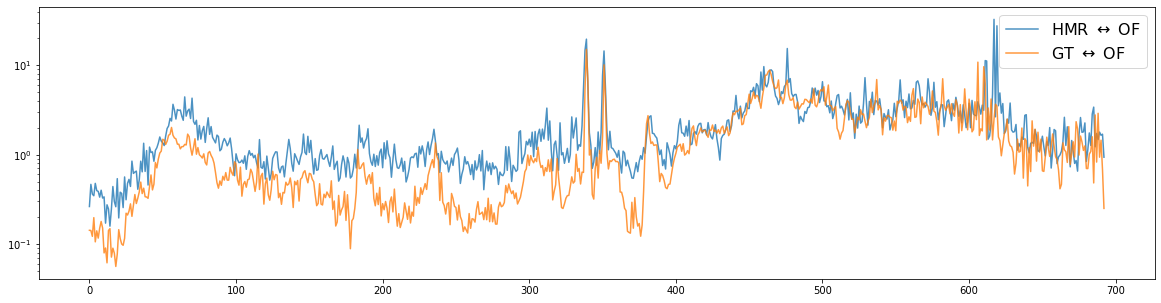

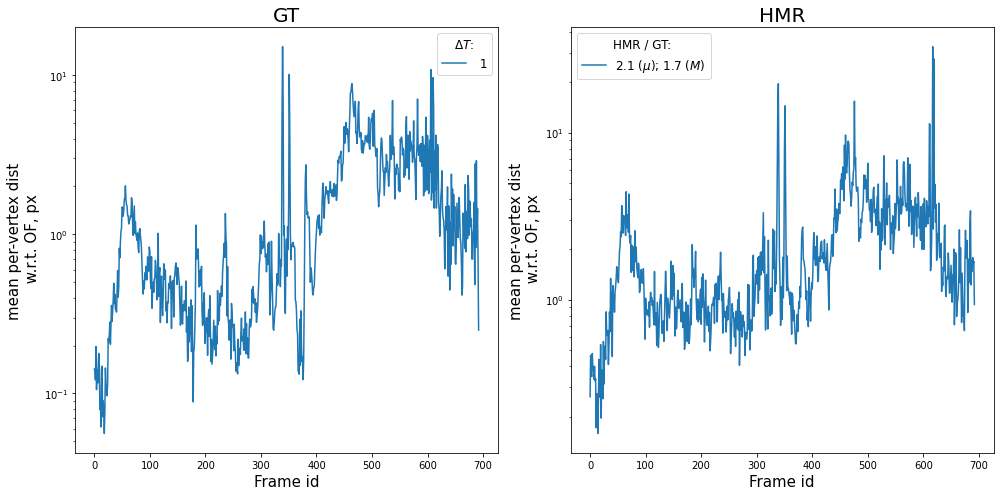

In [61]:
fig, ax = plt.subplots(1,1,figsize=(20,5))
# ax.semilogy(flow_loss_f_HMR_GT, label="HMR $\leftrightarrow$ GT", alpha=0.8)
ax.semilogy(flow_loss_f_HMR, label="HMR $\leftrightarrow$ OF", alpha=0.8)
ax.semilogy(flow_loss_f_GT, label="GT $\leftrightarrow$ OF", alpha=0.8)
ax.legend(fontsize=16)
# ax.set_xlim(0,len(flow_loss_f_GT))

fig, ax = plt.subplots(1,2, figsize=(14,7))
delta = 1
ax[0].semilogy(flow_loss_f_GT, label=f"{delta:2}")
ax[1].semilogy(flow_loss_f_HMR, 
               label=
               f"{(flow_loss_f_HMR/flow_loss_f_GT).mean():.1f} ($\mu$); "
               f"{(flow_loss_f_HMR/flow_loss_f_GT).median():.1f} ($M$)",
              )

ax[0].set_title("GT", fontsize=20)
ax[1].set_title("HMR", fontsize=20)
for axis in ax:
    axis.set_xlabel("Frame id", fontsize=15)
    axis.set_ylabel("mean per-vertex dist\n w.r.t. OF, px", fontsize=15)

ax[0].legend(fontsize=12, title="$\Delta T$: ", title_fontsize=12)
ax[1].legend(fontsize=12, title="HMR / GT: ", title_fontsize=12)

fig.tight_layout()
fig.patch.set_facecolor("white")

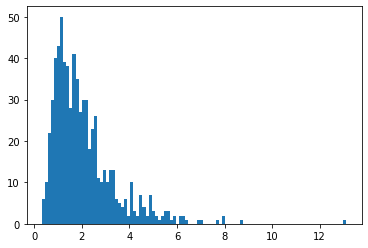

In [62]:
plt.hist(flow_loss_f_HMR / flow_loss_f_GT, bins=100);

In [63]:
print("percentage `HMR-OF` is worse than `GT-OF`:")
sum((flow_loss_f_HMR / flow_loss_f_GT) <= 1)/len(flow_loss_f_HMR) * 100

percentage `HMR-OF` is worse than `GT-OF`:


tensor(17.6046)

In [64]:
(flow_loss_f_HMR / flow_loss_f_GT).mean(), (flow_loss_f_HMR / flow_loss_f_GT).median()

(tensor(2.0763), tensor(1.7327))

# recompute for all vertices

In [79]:
flow_loss_f_GT = (verts2d_flow_f_GT - unproj_of_f_GT).norm(dim=-1)
flow_loss_f_GT = flow_loss_f_GT * vis_mask_GT # B * N
flow_loss_f_GT = flow_loss_f_GT[ids_pairs_mask]
flow_loss_f_GT = flow_loss_f_GT.flatten()

flow_loss_f_HMR = (verts2d_flow_f_HMR - unproj_of_f_HMR).norm(dim=-1)
flow_loss_f_HMR = flow_loss_f_HMR * vis_mask_HMR # B * N
flow_loss_f_HMR = flow_loss_f_HMR[ids_pairs_mask]
flow_loss_f_HMR = flow_loss_f_HMR.flatten()

nonzero_mask_GT_HMR = (flow_loss_f_GT > 0) * (flow_loss_f_HMR > 0)
flow_loss_f_GT = flow_loss_f_GT[nonzero_mask_GT_HMR]
flow_loss_f_HMR = flow_loss_f_HMR[nonzero_mask_GT_HMR]

HMR_GT_f_ratio = flow_loss_f_HMR / flow_loss_f_GT
print(HMR_GT_f_ratio.shape)

torch.Size([1403950])


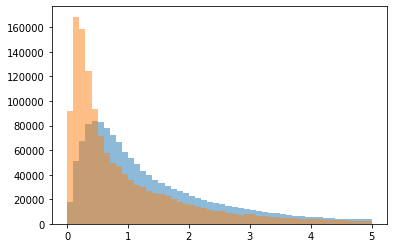

In [89]:
plt.hist(flow_loss_f_HMR, bins=50, range=(0.,5.), alpha=0.5);
plt.hist(flow_loss_f_GT, bins=50, range=(0.,5.), alpha=0.5);

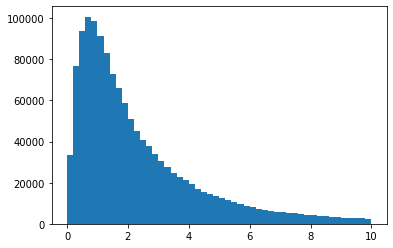

In [92]:
plt.hist(HMR_GT_f_ratio, bins=50, range=(0.,10.));

In [93]:
print("percentage `HMR-OF` is worse than `GT-OF`:")
print(sum((HMR_GT_f_ratio) <= 1)/len(HMR_GT_f_ratio) * 100)

percentage `HMR-OF` is worse than `GT-OF`:
tensor(28.7165)
